In [1]:

# Standard pacakges 
import torch 
from torch import nn, utils
import networkx as nx 
import numpy as np 
import matplotlib.pyplot as plt 

# Pytroch Geometric 
from torch_geometric import utils as gutils
from torch_geometric import nn as gnn # import layers 
from torch_geometric.datasets import Planetoid # import dataset CORA 


#### TODO: Model Training/Evaluation Class 

In [2]:
class model_utils: 
    def __init__(self, dataset, epochs): 
        # store the data
        # TODO: Change the raw dataset to a dataloader object from PyTorch
        self.dataset = dataset  
        if 'x' in self.dataset:
            self.node_features = self.dataset.x
        else: 
            print("Input Dataset has no node features.")
        self.edge_index = self.dataset.edge_index
        self.node_labels = self.dataset.y 

        # print some dataset statistics 
        print(f'Number of nodes: {dataset.num_nodes}')
        print(f'Number of edges: {dataset.num_edges}')
        print(f'Average node degree: {dataset.num_edges / dataset.num_nodes:.2f}')
        if 'train_mask' in dataset:
            print(f'Number of training nodes: {dataset.train_mask.sum()}')
            print(f'Training node label rate: {int(dataset.train_mask.sum()) / dataset.num_nodes:.2f}')
        print(f'Has isolated nodes: {dataset.has_isolated_nodes()}')
        print(f'Has self-loops: {dataset.has_self_loops()}')
        print(f'Is undirected: {dataset.is_undirected()}')


        # training/validation split

        # Hyperparameters 
        self.epochs = epochs
        self.train_loss = []
        self.validation_loss = []
        self.test_loss = 0 
        self.validation_acc = []
        self.test_acc = 0
        

    """
    Utility functions: 
    - load dataset 
    - loss function 
    - optimizer 
    - train/validation
    - test
    """

    def initialize_training(self): 
        """ Initialize Training Utilities """
        pass 

    def train_step(self): 
        """ One Training Step """
        pass

    def test(self): 
        pass


#### Custom GCN Layer for weight initialization

In [45]:
class GCNConvCustom(nn.Module):
    def __init__(self, 
                edge_index,
                # node_batch,
                input_dim, 
                output_dim, 
                random_init=True, 
                with_bias=True,
                device='cuda:0' if torch.cuda.is_available() else 'mps'):
        super(GCNConvCustom, self).__init__()
        # print("layer initialized")

        """Metadata"""
        self.device = device # initialize the hosting device
        self.with_bias = with_bias

        """Calculate Matrices"""
        # the adjacency matrix with self-loop 
        
        self.A = gutils.to_dense_adj(edge_index).to(self.device)[0]
        self.A_self = self.A + torch.diag(torch.ones(self.A.shape[0], device=self.device))
        # print("Adj Matrix with self loop: ", self.A)
        
        # calculate the degree matrix with A after added self loop
        self.D = torch.sum(self.A_self, dim=0).to(self.device)  # Note: these are the elements along the diagonal of D
        # print("Degree Matrix: ", self.D)

        # for diagonal matrix, raising it to any power is the same as raising its diagonal elements to that power
        # we can just apply the -1/2 power to all element of this degree matrix 
        # self.D_half_norm = torch.reciprocal(torch.sqrt(self.D)) 
        # self.D_half_norm = torch.from_numpy(fractional_matrix_power(self.D, -0.5)).to(self.device)
        self.D_half_norm = torch.diag(torch.pow(self.D, -0.5))
        # print("Normalization Matrix: ", self.D_half_norm)

        # normalized adjacency matrix
        # self.A_s = torch.mm(torch.mm(self.D_half_norm, self.A), self.D_half_norm) 
        self.A_s = self.D_half_norm @ self.A_self @ self.D_half_norm
        self.A_s = self.A_s.to(self.device)
        # print(self.A_s.shape)
        
        # initialize learnable weights
        # the weight should have shape of (N , F) where N is the size of the input, and F is the output dimension
        self.W, self.b = None, None
        if random_init: 
            self.W = torch.nn.Parameter(
                data=(torch.rand(input_dim, output_dim, device=self.device) * 0.01),  # times it by 0.001 to make the weight smaller
                requires_grad=True
            )
            # create trainable a bias term for the layer
            self.b = torch.nn.Parameter(
                data=(torch.rand(output_dim, 1, device=self.device) * 0.01),
                requires_grad=True
            )
        else: 
            self.W = torch.nn.Parameter(
                data=torch.ones(input_dim, output_dim, device=self.device), 
                requires_grad=True
            )
            self.b = torch.nn.Parameter(
                data=torch.ones(output_dim, 1, device=self.device), 
                requires_grad=True
            )

    def forward(self, H):
        if self.with_bias: 
            return self.A_s @ H @ self.W + self.b.T
        else: 
            return self.A_s @ H @ self.W

    def get_adj_matrix(self, with_self=False):
        if with_self: 
            return self.A_self 
        return self.A
    
    def get_normalized_adj_matrix(self): 
        return self.A_s

    def get_degree_matrix(self, normalization=False): 
        if normalization: 
            return self.D_half_norm
        return self.D


#### Temporally data reading function

In [4]:
def loader_cora_torch(filepath="../data/raw/Planetoid", transform=None, batch_size=1, shuffle=False, device='cuda:0' if torch.cuda.is_available() else 'mps'):
    """Return the CORA dataset"""
    dataset = Planetoid(root=filepath, name='Cora', split='public', num_train_per_class=20, num_val=500, num_test=1000, transform=transform) # return a class of datasets
    data = dataset[0]
    # print some dataset statistics 
    print(f'Loads Cora dataset, at root location: {filepath}')
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Number of training nodes: {data.train_mask.sum()}')
    print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

    return data.edge_index.to(device), data.x.to(device), data.y.to(device)


edge_index, node_features, labels = loader_cora_torch(shuffle=True) # load the cora dataset

Loads Cora dataset, at root location: ../data/raw/Planetoid
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [5]:
# test custom GCN Layer 
layer1 = GCNConvCustom(edge_index=edge_index, input_dim=node_features.shape[0], output_dim=10, random_init=False)
output1 = layer1(layer1.get_adj_matrix())
layer2 = GCNConvCustom(edge_index=edge_index, input_dim=10, output_dim=5, random_init=False)
layer2(output1)

tensor([[45.2056, 45.2056, 45.2056, 45.2056, 45.2056],
        [33.8967, 33.8967, 33.8967, 33.8967, 33.8967],
        [46.2932, 46.2932, 46.2932, 46.2932, 46.2932],
        ...,
        [10.0000, 10.0000, 10.0000, 10.0000, 10.0000],
        [47.9280, 47.9280, 47.9280, 47.9280, 47.9280],
        [50.5896, 50.5896, 50.5896, 50.5896, 50.5896]], device='cuda:0',
       grad_fn=<MmBackward0>)

#### Implementation of 2 GCN Convolution Layers Auto-encoder
reference: 
* https://towardsdatascience.com/tutorial-on-variational-graph-auto-encoders-da9333281129 

In [46]:
class GCN_AE(nn.Module): 
    """
    Graph Convolutional Auto-Encoder

    GCN layer implementation from: 
        https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv 
    """
    def __init__(self, 
                edge_index, 
                input_size, 
                hidden_size_1,
                hidden_size_2,
                encoding_size,
                device= 'cuda:0' if torch.cuda.is_available() else 'mps'): 
        super().__init__()
        # meta information
        self.device = device
        self.edge_index = edge_index # same as edge list, replace adjacency matrix 
        self.input_size = input_size
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.encoding_size = encoding_size

        # training utilities 
        self.criterion = None 
        self.optimizer = None 
        
        # layers 
        self.GCN_1 = GCNConvCustom(edge_index=self.edge_index, input_dim=self.input_size, output_dim=self.hidden_size_1, random_init=True, device=self.device) 
        self.GCN_2 = GCNConvCustom(edge_index=self.edge_index, input_dim=self.hidden_size_1, output_dim=self.hidden_size_2, random_init=True, device=self.device)
        self.FC = nn.Linear(in_features=self.hidden_size_2, out_features=self.encoding_size, device=self.device)

        # activations 
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encoder(self, X): 
        X_hat = self.GCN_1(X) # first layer: lower dimension feature matrix
        X_hat = self.relu(X_hat) 
        H = self.GCN_2(X_hat) # second layer: mean matrix
        H = self.relu(H)
        Z = self.FC(H)
        Z = self.relu(Z) # this activation may or may not be here, doesn't make a difference  
        return Z

    def decoder(self, Z): 
        # TODO: we don't want matrix product, but inner product of each encoded vector 
        Y_inner = torch.mm(Z, Z.T) # calculate inner product of matrix 
        # Y_inner = Y_inner.reshape((-1)) # flatten the tensor 
        Y = self.sigmoid(Y_inner) # apply activation 
        return Y

    def forward(self, X): 
        Z = self.encoder(X)
        output = self.decoder(Z)
        return output

    def set_optimizer(self, optimizer): 
        self.optimizer = optimizer

    def set_loss(self, criterion): 
        self.criterion = criterion

#### Implementation of 2 GCN Convolution Layers Variational Auto-encoder 
references: 
* https://towardsdatascience.com/tutorial-on-variational-graph-auto-encoders-da9333281129 
* https://github.com/tkipf/gae/blob/0ebbe9b9a8f496eb12deb9aa6a62e7016b5a5ac3/gae/model.py 

In [26]:
class GCN_VAE(nn.Module): 
    """
    Graph Variational Convolutional Auto-Encoder

    GCN layer implementation from: 
        https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv 
    """
    def __init__(self, 
                edge_index, 
                input_size, 
                hidden_size,
                encoding_size,
                output_size, 
                device= 'cuda:0' if torch.cuda.is_available() else 'mps'): 
        super().__init__()
        # meta information
        self.device = device
        self.edge_index = edge_index # same as edge list, replace adjacency matrix 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.encoding_size = encoding_size
        self.output_size = output_size
        
        # layers 
        self.GCN_1 = gnn.GCNConv(in_channels=self.input_size, out_channels=self.hidden_size, normalize=False, device=self.device) 
        self.GCN_2 = gnn.GCNConv(in_channels=self.hidden_size, out_channels=self.encoding_size, normalize=False, device=self.device)

        # activations 
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encoder(self, X): 
        X_hat = self.GCN_1(X, self.edge_index) # first layer: lower dimension feature matrix 
        X_hat = self.relu(X_hat)
        Z_mean = self.GCN_2(X_hat, self.edge_index) # second layer: mean matrix
        Z_logstd = self.GCN_2(X_hat, self.edge_index) # second layer: natural log of squared standard deviation
        Z_std = torch.sqrt(torch.exp(Z_logstd)) # calculate the standard deviation 
        Z = torch.normal(Z_mean, Z_std) # random sample from normal distribution with the calculated mean and std
        return Z

    def decoder(self, Z): 
        Y_inner = torch.mm(Z, Z.T) # calculate inner product of matrix 
        Y_inner = Y_inner.reshape((-1)) # flatten the tensor 
        Y = self.sigmoid(Y_inner) # apply activation 
        return Y

    def forward(self, X): 
        Z = self.encoder(X)
        output = self.decoder(Z)
        return output


#### Task 1
Create two 4-node graphs of your choice by hand on paper with node labels (but no attributes). Begin with a 2-hidden layer GCN with weight matrics initialized at 1. Calculate the feed-forward output of the graph by hand. Compare it to your results using PyTorch.

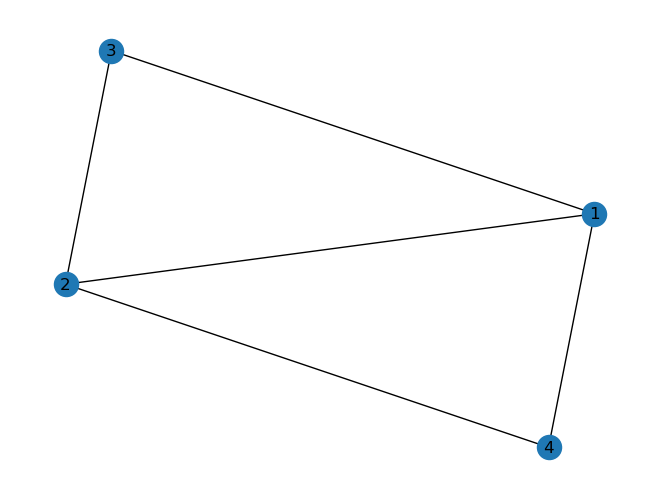

In [8]:
graph = nx.Graph()
graph.add_nodes_from([1,2,3,4])
graph.add_edges_from([(1,2), (2, 3), (1, 4), (4, 2), (3, 1)])
nx.draw(graph, labels={i:i for i in range(1, 5)})

Calculating the 2-hidden layer GCN-AE by hand. 

1. Adjacency Matrix 
    * Node 1 = [0, 1, 1, 1]
    * Node 2 = [1, 0, 1, 1]
    * Node 3 = [1, 1, 0, 0]
    * Node 4 = [1, 1, 0, 0]
$$ 
\LARGE{A} = \begin{pmatrix}
            0 & 1 & 1 & 1 \\
            1 & 0 & 1 & 1 \\
            1 & 1 & 0 & 0 \\
            1 & 1 & 0 & 0
            \end{pmatrix} \\

\text{ with self loop } = \begin{pmatrix}
            1 & 1 & 1 & 1 \\
            1 & 1 & 1 & 1 \\
            1 & 1 & 1 & 0 \\
            1 & 1 & 0 & 1
            \end{pmatrix} 
$$ 
We want to normalize the adjacency matrix by multiplying $D^{-\frac{1}{2}}$ on each sides: 
$$
\LARGE{D} = \begin{pmatrix} 
            4 & 0 & 0 & 0 \\
            0 & 4 & 0 & 0 \\
            0 & 0 & 3 & 0 \\
            0 & 0 & 0 & 3
            \end{pmatrix} \\
\LARGE{D}^{-\frac{1}{2}} = \begin{pmatrix} 
            \frac{1}{\sqrt{4}} & 0 & 0 & 0 \\
            0 & \frac{1}{\sqrt{4}} & 0 & 0 \\
            0 & 0 & \frac{1}{\sqrt{3}} & 0 \\
            0 & 0 & 0 & \frac{1}{\sqrt{3}}
            \end{pmatrix}
$$
$$
\LARGE{\hat{A}} = \LARGE{D}^{-\frac{1}{2}} \LARGE{A} \LARGE{D}^{-\frac{1}{2}} \\
    =   \begin{pmatrix}
        \frac{1}{4} &  \frac{1}{4} & \frac{1}{\sqrt{3}\sqrt{4}} & \frac{1}{\sqrt{3}\sqrt{4}} \\
        \frac{1}{4} &  \frac{1}{4} & \frac{1}{\sqrt{3}\sqrt{4}} & \frac{1}{\sqrt{3}\sqrt{4}} \\
        \frac{1}{\sqrt{3}\sqrt{4}} & \frac{1}{\sqrt{3}\sqrt{4}} & \frac{1}{3} & 0 \\
        \frac{1}{\sqrt{3}\sqrt{4}} & \frac{1}{\sqrt{3}\sqrt{4}} & 0 & \frac{1}{3}
        \end{pmatrix}
$$

2. Feature Matrix
    * We didn't specify any node feature, so this is going to be the identity matrix. 

3. First GCN layer (dim: 4 -> 2)
    * Weight Matrix: $$\LARGE{W_1} = \begin{pmatrix}
            1 & 1 \\
            1 & 1 \\
            1 & 1 \\
            1 & 1 
            \end{pmatrix}$$
    * Full Equation: $$ ReLU(\hat{A}XW) = ReLU(
            \begin{pmatrix}
            \frac{1}{4} &  \frac{1}{4} & \frac{1}{\sqrt{3}\sqrt{4}} & \frac{1}{\sqrt{3}\sqrt{4}} \\
            \frac{1}{4} &  \frac{1}{4} & \frac{1}{\sqrt{3}\sqrt{4}} & \frac{1}{\sqrt{3}\sqrt{4}} \\
            \frac{1}{\sqrt{3}\sqrt{4}} & \frac{1}{\sqrt{3}\sqrt{4}} & \frac{1}{3} & 0 \\
            \frac{1}{\sqrt{3}\sqrt{4}} & \frac{1}{\sqrt{3}\sqrt{4}} & 0 & \frac{1}{3}
            \end{pmatrix} \LARGE{X}
            \begin{pmatrix}
            1 & 1 \\
            1 & 1 \\
            1 & 1 \\
            1 & 1 
            \end{pmatrix})$$
    * Each node's representation after passing through this layer: 
        1. [1.07735027, 1.07735027]
        2. [1.07735027, 1.07735027]
        3. [0.9106836 , 0.9106836]
        4. [0.9106836 , 0.9106836]

4. Second GCN layer (dim: 2 -> 1)
    * Weight Matrix: $$\LARGE{W_2} = \begin{pmatrix}
            1 \\
            1 
            \end{pmatrix}$$
    * Each node's representation after passing through this layer: 
        1. [2.12891712]
        2. [2.12891712] 
        3. [1.85113934]
        4. [1.85113934]

In [33]:
# test the encoding in a 2 layer GCN 
edge_index = torch.tensor(list(graph.to_directed().edges)).T-1
device = 'cuda:0' if torch.cuda.is_available() else 'mps'
layer1 = GCNConvCustom(edge_index=edge_index, input_dim=4, output_dim=2, random_init=False, with_bias=False)
output1 = layer1(torch.eye(4).to(device))
layer2 = GCNConvCustom(edge_index=edge_index, input_dim=2, output_dim=1, random_init=False, with_bias=False)
layer2(output1)

tensor([[2.1289],
        [2.1289],
        [1.8511],
        [1.8511]], device='cuda:0', grad_fn=<MmBackward0>)

#### Task 2
Link Prediction with GCN-AE

Questions: 
* What is the loss function for the autoencoder and why is the setup appropriate for link-prediction? 
    - The idea of using a graph autoencoder for link prediction is to randomly take out part of the graph, and use the remaining portion of the graph to predict the removed portion of the graph. 
    - This process is similar to the encoding-decoding procedure of an autoencoder. The encoding is the model extracting information form the training portion of the graph. The decoding is the model reconstructing the connection of the test portion of the graph. 
    - The loss function of the autoencoder calculates the reconstruction loss, i.e. how different the reconstruction of the decoder is from the ground truth. One common approach is to use the MSE between the decoded tensor and the ground truth. 

* What if you wanted to take node attributes into account as well? 
    - For GCNs, the node attributes can just be passed into it as part of the encoding features, so there shouldn't be a difference in the procedure from the procedure without the node attributes. 

* How might you change the loss function?
    - Although link prediction problem can be understood as a reconstruct problem, it is also a classification problem. For each pair of nodes, there can only be two possibilities, link or no link. This indicates that we can use binary cross-entropy as the loss function, instead of mean square error. 

In [10]:
# data preparation 
"""
Strategy: 
* Randomly sample 50% edges (training), 20% edges (validation), and 30% edges (testing). 
* We want to evaluate against the edges that are uniformly distributed connected to each nodes, 
    so create a couple of random sampled train, validation, test datasets, evaluate the performance against each. 
"""
def extract_train_test_data(edge_index, node_features=None, labels=None, device='cuda:0' if torch.cuda.is_available() else 'mps'): 
    """
    Parameters
        edge_index: torch.Tensor, shape should be (2, # of edges in graph)
        node_features: troch.Tensor, shape should be (# of nodes, feature dimension)
        labels: torch.Tensor, shape should eb (# of nodes, )
        
    Return
        datasets: list, contain randomly sampled (train_matrix, validation_matrix, test_matix) dataset; same length as the number of trials specified. 
            train_matrix: sub-graph created by sampling 50% of the edges from the original graph 
            validation_matix: sub-graph created by sampling 20% of the edges from the original graph 
            test_matrix: sub-graph of the rest of the 30% of the original graph
    """
    num_edges = edge_index.shape[1] 
    train_size, val_size = int(0.5*num_edges), int(0.2*num_edges)
    test_size = num_edges - train_size - val_size
    print(f"""
            There are a total of {num_edges}. \n
            Train dataset has {train_size} edges. \n
            Validation dataset has {val_size} edges. \n
            Test dataset has {test_size} edges. 
          """)
   
    randomize_indices = torch.randperm(num_edges)
    train_indices, val_indices, test_indices = randomize_indices[:train_size], randomize_indices[train_size:train_size+val_size], randomize_indices[train_size+val_size:]
    train_matrix, validation_matrix, test_matrix = edge_index[:, train_indices], edge_index[:, val_indices], edge_index[:, test_indices] 
   
    return train_matrix.to(device), validation_matrix.to(device), test_matrix.to(device)
    
edge_index, node_features, labels = loader_cora_torch(shuffle=True, device='cuda:0' if torch.cuda.is_available() else 'mps') # load the cora dataset
train_subset, validation_subset, test_subset = extract_train_test_data(edge_index)

Loads Cora dataset, at root location: ../data/raw/Planetoid
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True

            There are a total of 10556. 

            Train dataset has 5278 edges. 

            Validation dataset has 2111 edges. 

            Test dataset has 3167 edges. 
          


In [47]:
model = GCN_AE(edge_index=train_subset, input_size=node_features.shape[1], hidden_size_1=30, hidden_size_2=10, encoding_size=5)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.set_optimizer(optimizer=optimizer)
model.set_loss(criterion=criterion)

In [48]:
Z = model(node_features)
Z 

tensor([[0.5010, 0.5010, 0.5010,  ..., 0.5010, 0.5010, 0.5009],
        [0.5010, 0.5009, 0.5009,  ..., 0.5010, 0.5009, 0.5009],
        [0.5010, 0.5009, 0.5009,  ..., 0.5010, 0.5009, 0.5009],
        ...,
        [0.5010, 0.5010, 0.5010,  ..., 0.5011, 0.5010, 0.5010],
        [0.5010, 0.5009, 0.5009,  ..., 0.5010, 0.5009, 0.5009],
        [0.5009, 0.5009, 0.5009,  ..., 0.5010, 0.5009, 0.5009]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
for epoch in range(300): 
    # train 
    model.train(True)
    train_running_loss = 0.0
    model.optimizer.zero_grad()
    output = model()
    